In [16]:
from __future__ import division, print_function
import sys
import itertools
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec
from matplotlib import colors

import pywcsgrid2
from astroquery.sdss import SDSS
from astropy.wcs import WCS
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.table as table
from astropy import coordinates as coords
import astropy.units as u

import K2fov.projection as proj
import K2fov.fov as fov
from K2fov.K2onSilicon import angSepVincenty,getRaDecRollFromFieldnum

import k2phot
from k2phot import centroid
from k2phot import tpf_io
from k2spin import prot
from hypra.utils import cat_match, cat_io, k2utils
from hypra.plot import color_mag
from hypra.plot.plot_k2 import plot_chips, setup_k2_axes
import convertmass

In [3]:
period_file_base = "../k2_tables/c5_k2sc_output_2016-05-17_"

for i in range(14):
    #print(i+1)
    period_file = "{0}{1}.csv".format(period_file_base,i+1)
    new_res = at.read(period_file)
    
    peak_file = "{0}{1}_allpeaks.csv".format(period_file_base,i+1)
    new_peaks = at.read(peak_file)
    if i==0:
        res = new_res
        peaks = new_peaks
    else:
        res = table.vstack([res,new_res])
        peaks = table.vstack([peaks,new_peaks])
print(len(res))
print(len(peaks),len(np.unique(peaks["EPIC"])))

699
1683 676


In [4]:
print(res.dtype)
c5_periods = res["sig_period"]
c5_power = res["sig_power"]
c5_epic = res["EPIC"]
c5_flag = res["num_sig"]
#c5_kpmag = res["magnitude"]
c5_harm = res["harm_type"]
c5_threshold = res["threshold"]

[('EPIC', '<i8'), ('fund_period', '<f8'), ('fund_power', '<f8'), ('sig_period', '<f8'), ('sig_power', '<f8'), ('sec_period', '<f8'), ('sec_power', '<f8'), ('num_sig', '<i8'), ('harm_type', 'S10'), ('threshold', '<f8')]


In [5]:
print(peaks.dtype)

[('EPIC', '<i8'), ('period', '<f8'), ('power', '<f8'), ('threshold', '<f8')]


In [6]:
def setup_figure():

    fig = plt.figure(figsize=(14,10))

    gs_base = gridspec.GridSpec(1,2,width_ratios=[1,3])

    gs_sky = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gs_base[0])

    sky_axes = [plt.subplot(gs_sky[i]) for i in range(3)]
    
    lc_n = 6

    gs_lc = gridspec.GridSpecFromSubplotSpec(lc_n,1,subplot_spec=gs_base[1])

    lc_axes = [plt.subplot(gs_lc[i]) for i in range(lc_n)]
    
    return fig, sky_axes, lc_axes

In [17]:
def k2sc_io(filename):
    """ Read in a K2SC light curve file, and return the time and flux.

    Flux is calculated as the completely detrended flux plus the
    time-dependent trend (i.e., only the position-dependent trend is removed),
    and then normalized.

    Inputs
    ------
    filename: string
        a valid K2SC file, including full or relative path

    Returns:
    --------
    time, flux, white: arrays

    """
    with fits.open(filename) as hdu:
        #print(hdu.info())

        tabl = hdu[1].data
        good = np.isfinite(tabl["flux"]) & (np.isfinite(tabl["trend_t"]))
        med_trend = np.median(tabl["trend_t"][good])
        time = tabl["time"][good]
        flux = tabl["flux"][good] + tabl["trend_t"][good] - med_trend

        white = tabl["flux"][good]
        
    return time,flux,white


In [35]:
def plot_phased(ax, t, f, period, power,color):
    
    phased_t = t % period / period
    
    ax.plot(phased_t,f,'.',color=color,label="Prot={0:.2f}, Power={1:.2f}".format(float(period),float(power)))
    ax.set_xlim(0,1)
    ax.set_yticklabels([])
    ax.legend(loc="best",numpoints=1,borderaxespad=0)

In [73]:
def plot_lcs(axes, EPIC):
    
    lc_file = "/home/stephanie/data/c5_k2sc/hlsp_k2sc_k2_llc_{0}-c05_kepler_v1_lc.fits".format(EPIC)
    t, f, w = k2sc_io(lc_file)
    
    i = np.where(res["EPIC"]==EPIC)[0]
    
    ylims = np.percentile(f,[0.05,99.05])
    
    color1 = plt.cm.inferno(0.5)
    color2 = plt.cm.inferno(0.75)
    
    # Periodogram
    ls_out = prot.run_ls(t,f,np.ones_like(f),0.1,prot_lims=[0.1,70],run_bootstrap=False)
    periods, pgram = ls_out[2], ls_out[3]
    
    axes[0].plot(periods,pgram,'k-')
    axes[0].set_xlim(0.1,70)
    axes[0].set_xscale("log")
    axes[0].plot(res[i]["sig_period"],res[i]["sig_power"]*1.1,'v',mfc=color1,mec="none",ms=11)
    axes[0].plot(res[i]["sec_period"],res[i]["sec_power"]*1.1,'v',mfc=color2,mec="none",ms=11)
    axes[0].set_ylim((0,res[i]["sig_power"]*1.15))
    axes[0].axhline(res[i]["threshold"],color='grey',ls="-.",
                    label="threshold {0:2f}".format(float(res[i]["threshold"])))
    #axes[0].set_xlabel("Period (d)",y=0.95)
    #axes[0].tick_params(labelbottom=False,labeltop=True)
    axes[0].set_xticklabels(["","0.1","1","10"])

    # Full light curve
    axes[1].plot(t,f,'k.')
    axes[1].set_ylim(ylims)
    axes[1].set_xlim(t[0],t[-1])
    axes[1].set_ylabel("LC")
    axes[1].set_yticklabels([])
    axes[1].tick_params(labelbottom=False)
    
    # White noise
    axes[2].plot(t,w,'k.')
    axes[2].set_ylim(np.percentile(w,[0.5,99.5]))
    axes[2].set_xlim(t[0],t[-1])
    axes[2].set_ylabel("WN")
    axes[2].set_yticklabels([])
    axes[2].tick_params(labelbottom=False)
    
    # Time-dependent trend
    axes[3].plot(t,f - w,'k.')
    axes[3].set_ylabel("T-dep")
    axes[3].set_xlim(t[0],t[-1])
    axes[3].set_yticklabels([])
    axes[3].tick_params(labelbottom=False)
    
    
    # Phase folded 1
    if res[i]["sig_period"]>0:
        plot_phased(axes[4],t,f,res[i]["sig_period"],res[i]["sig_power"],color=color1)
        axes[4].set_ylim(ylims)
        axes[4].set_ylabel("P1")

        if res[i]["sig_period"]>=2:
            repeats = np.arange(t[0],t[-1],res[i]["sig_period"])
            for r in repeats:
                axes[1].axvline(r,ls="--",color=color1,lw=1.5)
        axes[4].tick_params(labelbottom=False)

    
    # Phase folded 2
    if res[i]["sec_period"]>0:
        plot_phased(axes[5],t,f,res[i]["sec_period"],res[i]["sec_power"],color=color2)
        axes[5].set_ylim(ylims)
        axes[5].set_ylabel("P2")

        if res[i]["sec_period"]>=2:
            repeats = np.arange(t[0],t[-1],res[i]["sec_period"])
            for r in repeats:
                axes[1].axvline(r,ls=":",color=color2)
                
    axes[5].set_xlim(0,1)
    axes[5].set_xlabel("Phase")

In [56]:
def stamp(img, maskmap, ax=None, cmap="cubehelix"):
    """Plot a single pixel stamp."""

    if ax is None:
        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(111)

    ax.matshow(img, cmap=cmap, origin="lower", norm=colors.LogNorm())
    ax.set_xlim(-0.5,maskmap.shape[1]-0.5)
    ax.set_ylim(-0.5,maskmap.shape[0]-0.5)
    # I remain unconvinced that these are labelled right...
    # but the coordinates are plotting right, and this matches the DSS images 
    # (except East and West are flipped)!
    ax.set_ylabel("Y")
    ax.set_xlabel("X")

    return ax


In [57]:
def extract_wcs(dataheader):
    """
    Genderate WCS for a K2 TPF, since astropy has decided not to cooperate.
    
    dataheader is the header of extension #1 (zero-indexing!) of a K2 TPF
    """
    w4 = WCS(naxis=2)

    w4.wcs.crpix = [dataheader["1CRPX4"],dataheader["2CRPX4"]]
    w4.wcs.cdelt = np.array([dataheader["1CDLT4"],dataheader["2CDLT4"]])
    w4.wcs.crval = [dataheader["1CRVL4"],dataheader["2CRVL4"]]
    w4.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w4.wcs.pc = [[dataheader["11PC4"],dataheader["12PC4"]],
                 [dataheader["21PC4"],dataheader["22PC4"]]]
    return w4

In [69]:
def plot_sky(axes, EPIC):
    
    
    # Get K2 image
    tpf_file = "/home/stephanie/data/c5_tpf/ktwo{0}-c05_lpd-targ.fits.gz".format(EPIC)
    tabl, times, pixels, maskmap, maskheader, kpmag = tpf_io.get_data(tpf_file)
    coadd = np.sum(pixels,axis=0)
    pos = coords.SkyCoord(maskheader["RA_OBJ"], maskheader["DEC_OBJ"],
                          unit=u.deg)
    
    with fits.open(tpf_file) as hdu2:
        dataheader = hdu2[1].header

#     keysel = np.empty(13, "S6")
#     keysel[:] = "binary"
    w2 = extract_wcs(dataheader)


    # Get SDSS image
    xid = SDSS.query_region(pos)
    one_match = table.Table(xid[0])
    im = SDSS.get_images(matches=one_match, band='r')
    pix = im[0][0].data
    hdr = im[0][0].header

    
    # Plot K2 image
    # Set up the GridHelper to merge the axes
    grid_helper = pywcsgrid2.GridHelper(wcs=w2)

    # Plot the pixel stamp as usual, except with the WCS
    ax1 = pywcsgrid2.subplot(341, grid_helper=grid_helper,
                             aspect=1, adjustable="box-forced")
    ax1.matshow(coadd, origin="lower", cmap="inferno", norm=colors.LogNorm())
    if pix is not None:
        median = np.median(pix)
        stdev = np.std(pix)
        levels = np.linspace(median + stdev, np.max(pix), 20)
        ax1[hdr].contour(pix,colors="w", levels=levels)
    
        # Plot the SDSS image rotated into the same frame as the pixel stamp
        ax2 = pywcsgrid2.subplot(345, grid_helper=grid_helper,
                                 aspect=1, adjustable="box-forced",
                                 sharex=ax1, sharey=ax1)
        ax2[hdr].imshow_affine(pix, origin="lower", cmap='Greys', 
                               norm=colors.LogNorm())
        median2 = np.median(coadd)
        stdev2 = np.std(coadd)
        levels2 = np.linspace(median, np.max(coadd), 5)    
    
    # Plot chip image - not working?
    ax3 = plt.subplot(349)
    ax3.plot(pos.ra.value,pos.dec.value,'*',color=plt.cm.inferno(0.2),ms=20)
    plot_chips(axes[2], 5)
    setup_k2_axes(axes[2], extents=None)
    ax3.set_yticks(np.arange(8,25,4))
    ax3.set_yticks(np.arange(8,24,2),minor=True)
    ax3.set_xticks(np.arange(122,139,4))
    ax3.set_xticks(np.arange(122,139,2),minor=True)
    ax3.set_xlabel(r"$\alpha_{2000}$")
    ax3.set_ylabel(r"$\delta_{2000}$")    

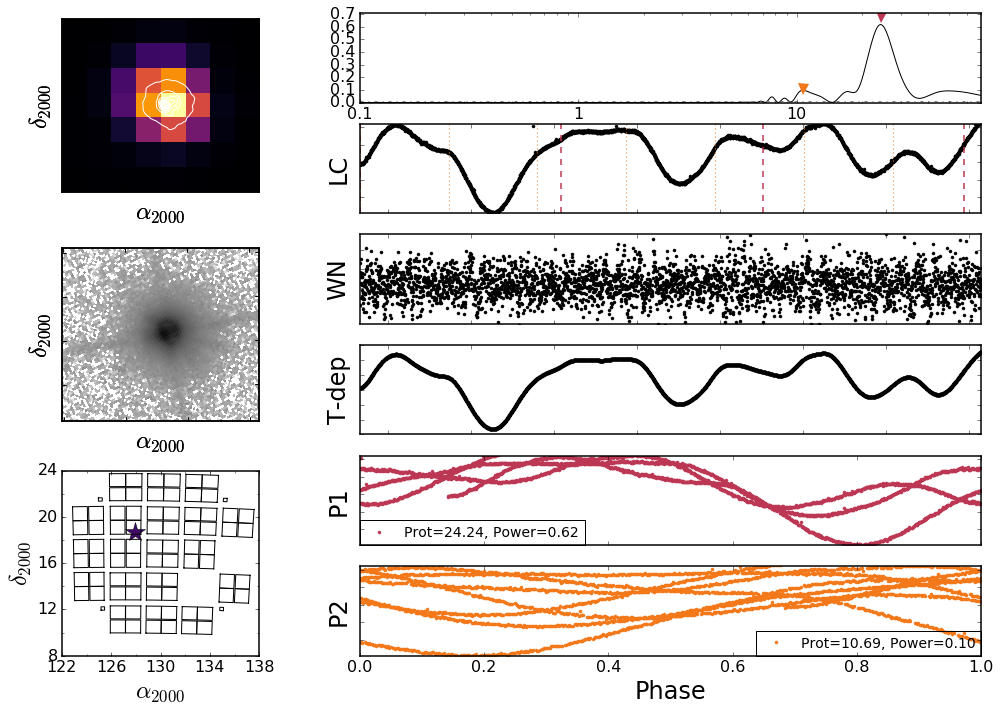

In [72]:
fig, sky_axes, lc_axes = setup_figure()
plot_sky(sky_axes,211897926)
plot_lcs(lc_axes,211897926)
plt.tight_layout()

# Everything below is from testing/debugging

In [16]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u

from k2phot import centroid

EPIC = 211897926
tpf_file = "/home/stephanie/data/c5_tpf/ktwo{0}-c05_lpd-targ.fits.gz".format(EPIC)
table, times, pixels, maskmap, maskheader, kpmag = tpf_io.get_data(tpf_file)

In [17]:
SDSS.query_region?

In [18]:
pos = coords.SkyCoord(maskheader["RA_OBJ"], maskheader["DEC_OBJ"],
                      unit=u.deg)
print(pos)
xid = SDSS.query_region(pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (127.962195, 18.696431)>


In [19]:
from astropy.table import Table
print(xid[0])
print(type(xid[0]))
one_match = Table(xid[0])
print(type(one_match))

      ra          dec             objid        run  rerun camcol field
------------- ------------ ------------------- ---- ----- ------ -----
127.962073805 18.696366976 1237667255603363984 5071   301      6    95
<class 'astropy.table.row.Row'>
<class 'astropy.table.table.Table'>


In [20]:
im = SDSS.get_images(matches=one_match, band='r')

In [21]:
im

[[<astropy.io.fits.hdu.image.PrimaryHDU at 0x7f4c33cc1450>,

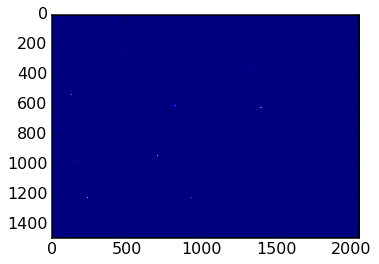

In [52]:
plt.imshow(im[0][0].data)

In [60]:
# Get K2 image
tpf_file = "/home/stephanie/data/c5_tpf/ktwo{0}-c05_lpd-targ.fits.gz".format(EPIC)
table, times, pixels, maskmap, maskheader, kpmag = tpf_io.get_data(tpf_file)
coadd = np.sum(pixels,axis=0)
pos = coords.SkyCoord(maskheader["RA_OBJ"], maskheader["DEC_OBJ"],
                      unit=u.deg)

with fits.open(tpf_file) as hdu2:
    dataheader = hdu2[1].header

keysel = np.empty(13, "S6")
keysel[:] = "binary"
w2 = WCS(dataheader, colsel=[5])#, keysel=keysel)


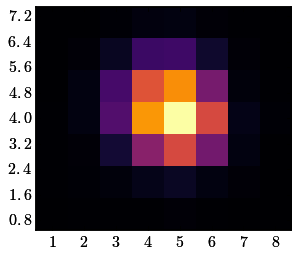

In [61]:
# Plot K2 image
# Set up the GridHelper to merge the axes
grid_helper = pywcsgrid2.GridHelper(wcs=w2)

# Plot the pixel stamp as usual, except with the WCS
ax1 = pywcsgrid2.subplot(111, grid_helper=grid_helper,
                         aspect=1, adjustable="box-forced")
ax1.matshow(coadd, origin="lower", cmap="inferno", norm=colors.LogNorm())

# pix = im[0][0].data
# hdr = im[0][0].header

# median = np.median(pix)
# stdev = np.std(pix)
# levels = np.linspace(median + stdev, np.max(pix), 5)
# ax1[hdr].contour(pix,colors="r", levels=levels)


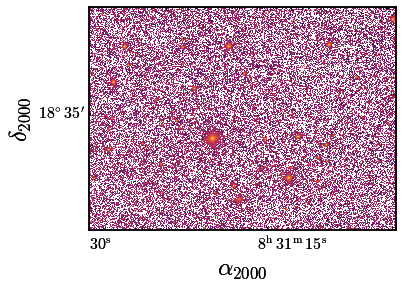

In [62]:

pix = im[0][0].data
hdr = im[0][0].header

w3 = WCS(hdr)

median = np.median(pix)
stdev = np.std(pix)
levels = np.linspace(median + stdev, np.max(pix), 5)
ax1[hdr].contour(pix,colors="r", levels=levels)

# Set up the GridHelper to merge the axes
grid_helper = pywcsgrid2.GridHelper(wcs=w3)

# Plot the pixel stamp as usual, except with the WCS
ax1 = pywcsgrid2.subplot(111, grid_helper=grid_helper,
                         aspect=1, adjustable="box-forced")
ax1.matshow(pix, origin="lower", cmap="inferno", norm=colors.LogNorm())


In [75]:
dataheader

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2188 / length of first array dimension                
NAXIS2  =                 3470 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   13 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [83]:
w4 = WCS(naxis=2)

w4.wcs.crpix = [dataheader["1CRPX4"],dataheader["2CRPX4"]]
w4.wcs.cdelt = np.array([dataheader["1CDLT4"],dataheader["2CDLT4"]])
w4.wcs.crval = [dataheader["1CRVL4"],dataheader["2CRVL4"]]
w4.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w4.wcs.pc = [[dataheader["11PC4"],dataheader["12PC4"]],
             [dataheader["21PC4"],dataheader["22PC4"]]]
print(w4)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 59.812605000000005  16.664425999999999  
CRPIX : 5.2035541791540254  5.3192324969234619  
PC1_1 PC1_2  : -0.90670603919463033  -0.42393841740163485  
PC2_1 PC2_2  : 0.42351299079531063  -0.90487604302488445  
CDELT : -0.0011056457821280001  0.0011056457821280001  
NAXIS    : 0 0


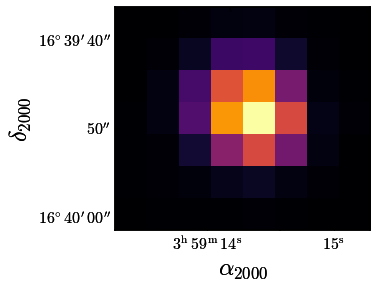

In [84]:
grid_helper = pywcsgrid2.GridHelper(wcs=w4)

# Plot the pixel stamp as usual, except with the WCS
ax1 = pywcsgrid2.subplot(111, grid_helper=grid_helper,
                         aspect=1, adjustable="box-forced")
ax1.matshow(coadd, origin="lower", cmap="inferno", norm=colors.LogNorm())



In [74]:
c4_tpf = "/home/stephanie/data/c4_tpf/ktwo{0}-c04_lpd-targ.fits".format(210579563)
with fits.open(c4_tpf) as hdu2:
    dataheader = hdu2[1].header

keysel = np.empty(13, "S6")
keysel[:] = "binary"
w2 = WCS(dataheader, colsel=[2])#, keysel=keysel)

print(w2)
w2.wcs.print_contents()

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS    : 2188 3470
